In [1]:
import tidy3d as td
import numpy as np
import matplotlib.pyplot as plt

Tidy3D classes `TriangularGridDataset` and `TetrahedralGridDataset` provide convenient way to interact with unstructured datasets. In their core they store three fields:
- `points`: coordinates of all grid points as a `PointDataArray` (`dims=(index, axis)`). `TriangularGridDataset` stores only in-plane 2d coordinates (`axis = 0, 1`), while `TetrahedralGridDataset` stores 3d coordinates (`axis = 0, 1, 2`).
- `cells`: grid cells connections as a `CellDataArray` (`dims=(cell_index, vertex_index)`). That is, `cells[i, :]` stores indices of 3/4 points composing the i-th triangle/tetrahendrol.
- `values`: data values at each grid point as a `IndexedDataArray` (`dims=(index,)`).
  
Additionally, `TriangularGridDataset` stores two more parameters `normal_axis` and `normal_pos` which define the planar grid normal and position of the grid along that direction in 3d.

Let us create a simple instances of both classes.

In [2]:
tri_grid_points = td.PointDataArray(
    [[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0]],
    coords=dict(index=np.arange(4), axis=np.arange(2)),
)

tri_grid_cells = td.CellDataArray(
    [[0, 1, 2], [1, 2, 3]],
    coords=dict(cell_index=np.arange(2), vertex_index=np.arange(3)),
)

tri_grid_values = td.IndexedDataArray(
    [1.0, 2.0, 3.0, 4.0], coords=dict(index=np.arange(4)),
)

tri_grid = td.TriangularGridDataset(
    normal_axis=1,
    normal_pos=0,
    points=tri_grid_points,
    cells=tri_grid_cells,
    values=tri_grid_values,
)

In [3]:
tet_grid_points = td.PointDataArray(
    [[0.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 1.0, 0.0], 
     [0.0, 0.0, 1.0], [1.0, 0.0, 1.0], [0.0, 1.0, 1.0], [1.0, 1.0, 1.0]],
    coords=dict(index=np.arange(8), axis=np.arange(3)),
)

tet_grid_cells = td.CellDataArray(
    [[0, 1, 3, 7], [0, 1, 5, 7], [0, 4, 5, 7], [0, 2, 3, 7], [0, 2, 6, 7], [0, 4, 6, 7]],
    coords=dict(cell_index=np.arange(6), vertex_index=np.arange(4)),
)

tet_grid_values = td.IndexedDataArray(
    [1.0, 2.0, 3.0, 4.0, 2.0, 4.0, 6.0, 8.0], coords=dict(index=np.arange(8)),
)

tet_grid = td.TetrahedralGridDataset(
    points=tet_grid_points,
    cells=tet_grid_cells,
    values=tet_grid_values,
)

Another convenient way of initializing unstructured grids is by reading them from vtk files containing `vtkUnstructuredGrid`.

In [4]:
heat_data = td.TetrahedralGridDataset.from_vtu("heat_sim_solution.vtu")

## Slicing and plotting

`TriangularGridDataset` can be directly immediately using function `.plot()`.

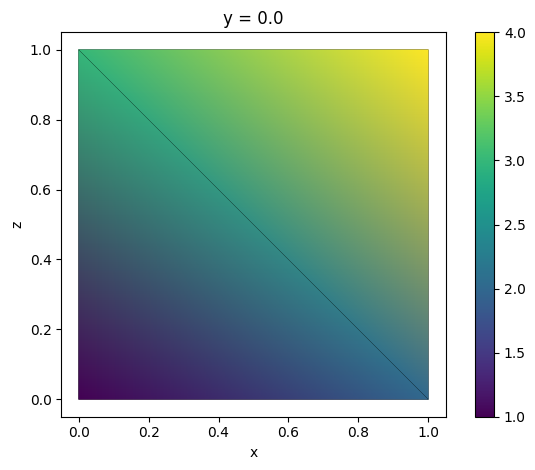

In [5]:
tri_grid.plot()
plt.show()

To visually inspect `TetrahedralGridDataset` one first needs to slice it along a plane. This creates a new `TriangularGridDataset` representing the grid slice. Note that slicing a tetrahedral grid might produce non-triangular polygons. Those are automatically triangulated.

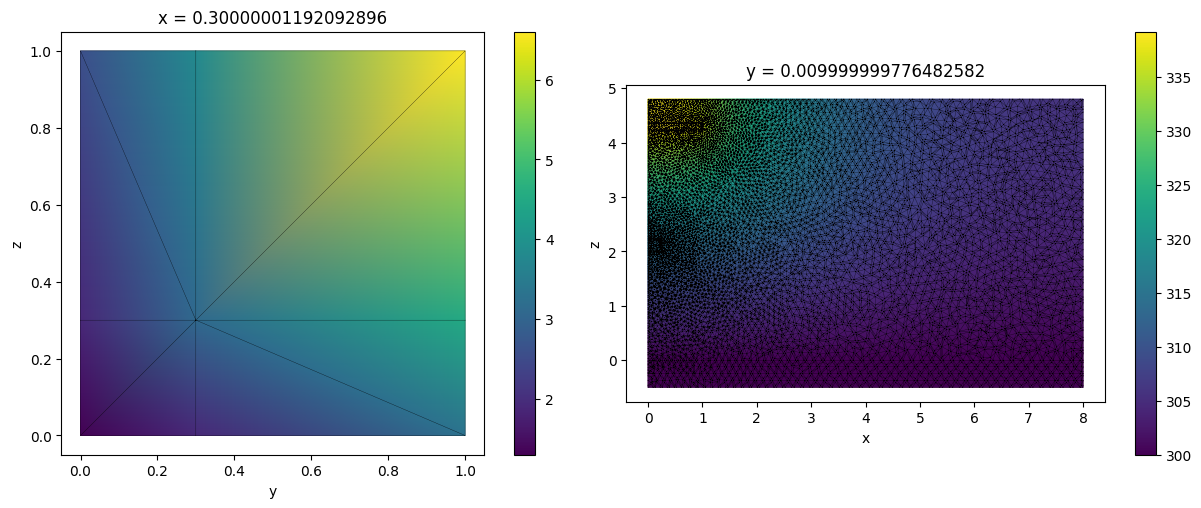

In [6]:
tet_grid_slice = tet_grid.plane_slice(axis=0, pos=0.3)
heat_data_slice = heat_data.plane_slice(axis=1, pos=0.01)

_, ax = plt.subplots(1, 2, figsize=(13, 5))
tet_grid_slice.plot(ax=ax[0])
heat_data_slice.plot(ax=ax[1])
plt.tight_layout()
plt.show()

By default both data and unstructured grid are plotted. Using boolean arguments `grid` and `field` plotting of either can be turned off.

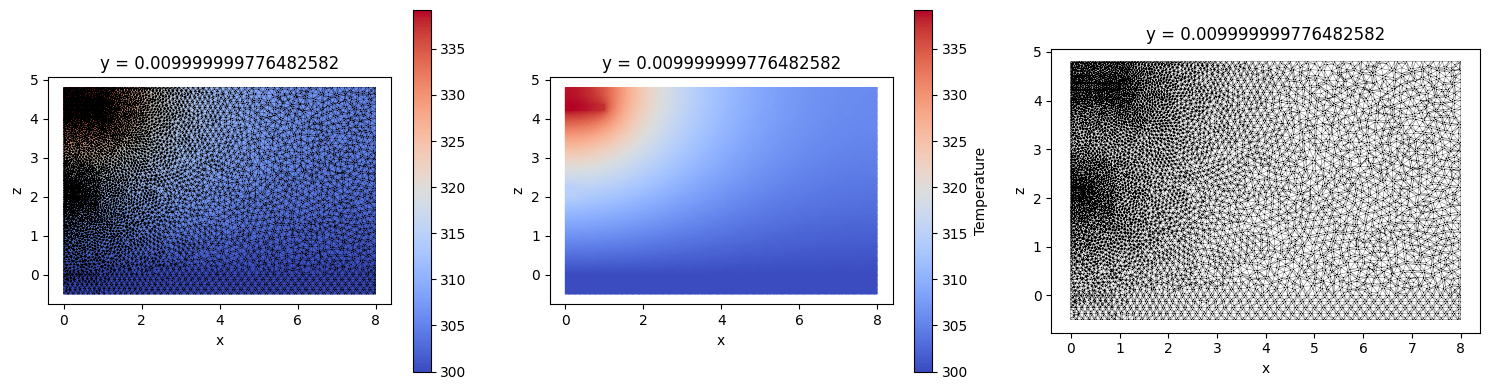

In [7]:
_, ax = plt.subplots(1, 3, figsize=(15, 4))
heat_data_slice.plot(ax=ax[0], cmap = "coolwarm")
heat_data_slice.plot(ax=ax[1], grid=False, cmap = "coolwarm", cbar_kwargs={"label": "Temperature"})
heat_data_slice.plot(ax=ax[2], field=False, cmap = "coolwarm")
plt.tight_layout()
plt.show()

`TriagnularGridDataset` similarly has a method `.plane_slice` and the result of this operation is a line represented as a `SpatialDataArray`. Note that the slicing plane must be perpendicular to the grid plane.

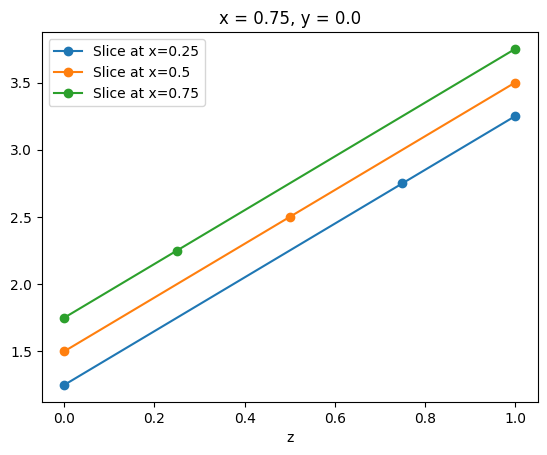

In [8]:
_, ax = plt.subplots(1, 1)

for x_pos in [0.25, 0.5, 0.75]:
    tri_grid_slice = tri_grid.plane_slice(axis=0, pos=x_pos)
    tri_grid_slice.plot(ax=ax, marker='o', label=f"Slice at x={x_pos}")

plt.legend()
plt.show()

A line slice from a tetrahedral grid can be obtained directly using method `.line_slice()`. This is similar to performing two plane slices.

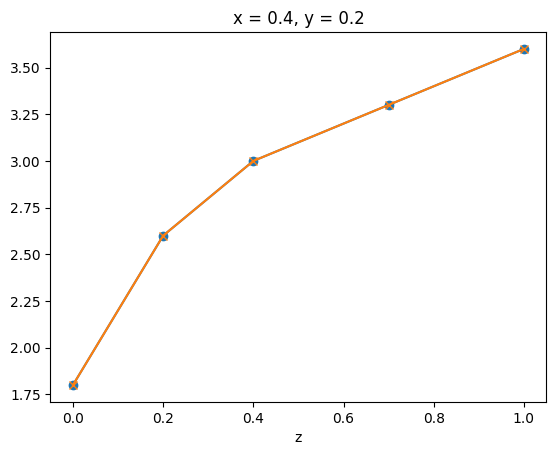

In [9]:
tet_grid_line_slice = tet_grid.line_slice(axis=2, pos=[0.4, 0.2, 0])
tet_grid_line_slice2 = tet_grid.plane_slice(axis=0, pos=0.4).plane_slice(axis=1, pos=0.2)

_, ax = plt.subplots(1, 1)
tet_grid_line_slice.plot(ax=ax, marker='o')
tet_grid_line_slice2.plot(ax=ax, marker='x')
plt.show()

Note that attempting to slice a grid out of bounds causes an error.

In [10]:
try:
    _ = tet_grid.plane_slice(axis=2, pos=2)
except:
    print("Oh-oh")
    
try:
    _ = tet_grid.line_slice(axis=1, pos=(3, 3, 3))
except:
    print("Oh-oh again")

21:18:07 CST ERROR: Slicing plane (axis: 2, pos: 2) does not intersect the      
             unstructured grid (extent along axis 2: 0.0, 1.0).                 

Oh-oh


             ERROR: Slicing line does not intersect the unstructured grid.      

Oh-oh again


## Clipping

Both datasets support method `.box_clip()` that clip grid data by a box.

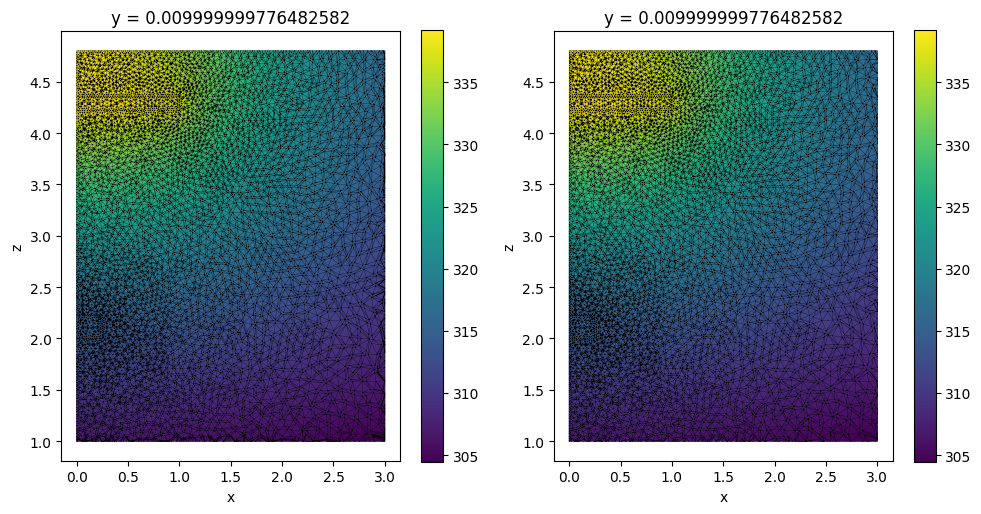

In [11]:
clip_bounds = [[0, -2.5, 1], [3, 2.5, 5]]
heat_data_clipped = heat_data.box_clip(bounds=clip_bounds)
heat_data_slice_clipped = heat_data_slice.box_clip(bounds=clip_bounds)

_, ax = plt.subplots(1, 2, figsize=(10, 5))

heat_data_clipped.plane_slice(axis=1, pos=0.01).plot(ax=ax[0])
heat_data_slice_clipped.plot(ax=ax[1])

plt.tight_layout()
plt.show()

Similarly to slicing, if the clipping box does not intersect the unstructured grid an error occurs.

In [12]:
try:
    _ = heat_data.box_clip(bounds=[[0, 1.5, 1], [3, 2.5, 5]])
except:
    print("Oh-oh-oh")

             ERROR: Clipping box does not intersect the unstructured grid.      

Oh-oh-oh


## Interpolation

Both methods support method `.interp()` that performs interpolation from an unstructured grid to a Cartesian grid defined by provided x, y, and z coordinates. The results are returned in as a `SpatialDataArray`. Note that performing interpolation into three dimensional Cartesian grid with many point may be slow. Points outside of unstructured grids are assigned to value provided as `fill_value` (default: 0).

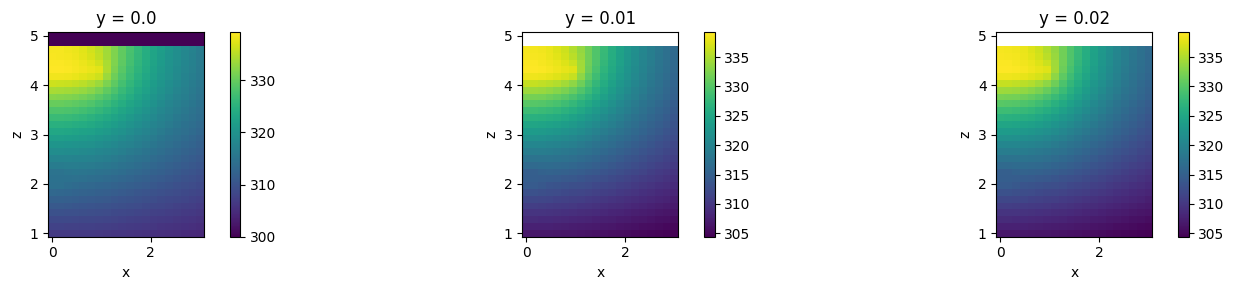

In [13]:
heat_data_interpolated = heat_data.interp(
    x=np.linspace(0, 3, 20), 
    y=np.linspace(-2.5, 2.5, 11),
    z=np.linspace(1, 5, 30),
    fill_value=300,
)

heat_data_slice_interpolated = heat_data_slice.interp(
    x=np.linspace(0, 3, 20), 
    y=[heat_data_slice.normal_pos, 0.02],
    z=np.linspace(1, 5, 30),
    fill_value=np.nan,
)
_, ax = plt.subplots(1, 3, figsize=(15, 3))

heat_data_interpolated.sel(y=0.01, method="nearest").plot(ax=ax[0], x="x")
heat_data_slice_interpolated.sel(y=0.01, method="nearest").plot(ax=ax[1], x="x")
heat_data_slice_interpolated.sel(y=0.02, method="nearest").plot(ax=ax[2], x="x")

ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
ax[2].set_aspect("equal")

plt.tight_layout()
plt.show()

By default the data stored `TriangularGridDataset` is assumed to be invariant along the normal direction to the grid plane, what is demonstrated in the above plots. This behavior can be turned off by passing an optional parameter `ignore_normal_pos=False`. However, in this case the results might be unpredictable because numerical precision can cause in-plane points to be considered out of plane. 

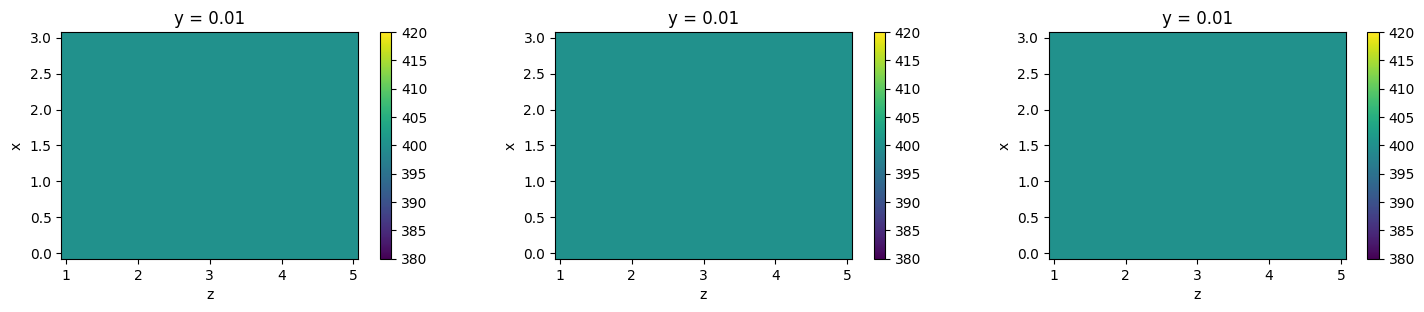

In [14]:
y_pos = [0.01, np.float32(0.01), np.float64(0.01)]

heat_data_slice_interpolated2 = heat_data_slice.interp(
    x=np.linspace(0, 3, 20), 
    y=y_pos,
    z=np.linspace(1, 5, 30),
    ignore_normal_pos=False,
    fill_value=400,
)

slices = [
    heat_data_slice_interpolated2.isel(y=y_ind)
    for y_ind in range(len(y_pos))
]

_, ax = plt.subplots(1, 3, figsize=(15, 3))

for i in range(3):
    slices[i].plot(ax=ax[i])
    ax[i].set_aspect("equal")

plt.tight_layout()
plt.show()

## General `.sel()` methods

For convenience the above slicing and extraction methods are wrapped by a single method `.sel()` that takes up to three arguments `x`, `y`, and `z`. The following are equivalence rules for `TetrahedralGridDataset`:
- `.sel` with one argument == `.plane_slice()`
- `.sel` with two arguments == `.line_slice()`
- `.sel` with all three arguments == `.interp()`
  
Similarly, for `TriangularGridDataset` (provided argument along normal axis is not provided):
- `.sel` with one argument == `.plane_slice()`
- `.sel` with two arguments == `.interp()`

## Reading and writing

As any other Tidy3D dataset these datasets can be written and read into/from `.hdf5` files. We also already saw method `.from_vtk()` that allow to initialize an unstructured dataset directly from a vtk file. Additionally, an unstructured dataset can be directly written into a vtk file using `.to_vtk()`. This could be useful when one desires to inspect a given unstructured data in another, perhaps more advanced, visualization software.

In [15]:
tri_grid.to_vtu("tri_grid_test.vtu")
tet_grid.to_vtu("tet_grid_test.vtu")

tri_grid_loaded = td.TriangularGridDataset.from_vtu("tri_grid_test.vtu")
tet_grid_loaded = td.TetrahedralGridDataset.from_vtu("tet_grid_test.vtu")

assert tri_grid == tri_grid_loaded
assert tet_grid == tet_grid_loaded
